# Gaussian filter and adaptative filter

---

##TODO

Avx:

- setup exp function

Also:

- adapt for halo that not multiple of 8
- adapt with smaller input
- different gaussians for bilateral and gaussian

Report:

- write about the code
- think about how much memory is communicated
- find parallelism

---

## Finiding the algorithm

In [1]:
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.ndimage.filters import gaussian_filter1d, gaussian_filter
%matplotlib inline

In [2]:
# function input
truncate = 4.
sigma = 4.
imagename = 'small.png'

In [3]:
# get ideal side sizes from arguments
lw = int(truncate*sigma+0.5)
pan = 2*lw+1

# for now we take values on the right until it fills a multiple of 8
# AVX is in x direction (in the matrix)
span = (pan // 8 + 1) * 8

# load image (only one color now)
f = misc.imread(imagename)
f = f[:,:,0]
output = f*0.

# add span-1 the -1 is because there is always at least one from the original image
lx, ly = f.shape
spx, spy = np.array([lx + span-1, ly + pan-1])

### Periodic B.C. and image we will work on

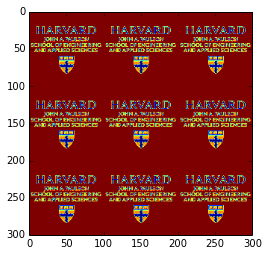

In [4]:
# add halo (periodic boundary condition, we could do something better but we don't have time to mess around with indexes...)
input = np.zeros((3*lx,3*ly))
for i in range(3):
    for j in range(3):
            input[i*lx:(i+1)*lx, j*ly:(j+1)*ly] = f

plt.imshow(input)

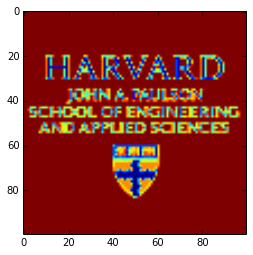

In [5]:
# plot the input image
plt.imshow(input[lx:2*lx, ly:2*ly]);

### gaussian filter

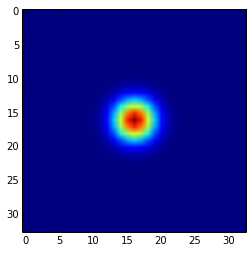

In [6]:
gaussianfilter = np.zeros((pan,pan))
for i in range(0,lw+1):
    for j in range(0,lw+1):
        gaussianfilter[i+lw,j+lw] = np.linalg.norm([i,j])
        gaussianfilter[-i+lw,-j+lw] = np.linalg.norm([i,j])
        gaussianfilter[-i+lw,j+lw] = np.linalg.norm([i,j])
        gaussianfilter[i+lw,-j+lw] = np.linalg.norm([i,j])
        
gaussianfilter = np.array(gaussianfilter)
gaussianfilter **= 2
gaussianfilter *= -.5/sigma
gaussianfilter = np.exp(gaussianfilter)
gaussianfilter /= np.sum(gaussianfilter)
plt.imshow(gaussianfilter)

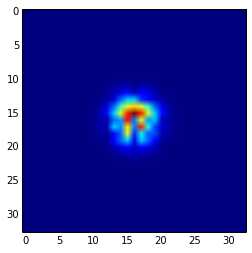

In [7]:
i = lx + 50
j = ly + 35
local_input = input[i-lw:i+lw+1, j-lw:j+lw+1]
plt.imshow(local_input*gaussianfilter);

python 0.728147983551


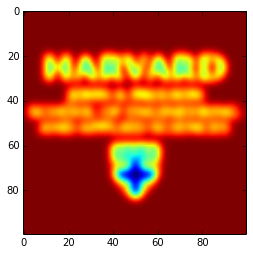

In [8]:
output_ini = output * 0
start = time.time()
for i in range(lx,2*lx):
    for j in range(ly,2*ly):
        local_input = input[i-lw:i+lw+1, j-lw:j+lw+1]
        output_ini[i-lx,j-ly]= np.sum(local_input*gaussianfilter)
plt.imshow(output_ini);
print "python", time.time() - start

scipy 0.147526979446


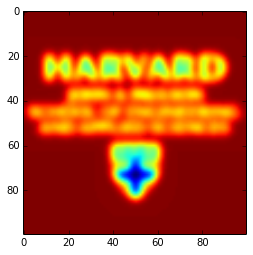

In [9]:
start = time.time()
blur = gaussian_filter(f, 2)
plt.imshow(blur);
print "scipy", time.time() - start

Our algorithm seems to be in good agreement with the Scipy function.

---

## Transition to AVX algorithm

Instead of precomputing the gaussian kernel, we will compute it for each pixel.
The python code will be much slower. However, when going parallel, it will limit the amount of data to move. There will also be no work around when transitioning to bilateral filter when the weight in every pixel is different.

computing one line each time

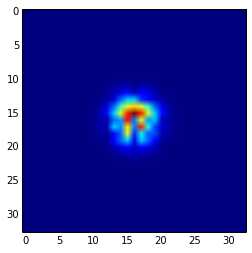

In [10]:
i = lx + 50
j = ly + 35
local_input = input[i-lw:i+lw+1, j-lw:j+lw+1]
toplot = local_input*0
sumg = 0

for k in range(pan):
    gaussian = [np.exp(-.5/sigma*np.linalg.norm([k-lw,_])**2) for _ in range(-lw,lw+1)]
    toplot[k,:] = local_input[k,:] * gaussian
    sumg += np.sum(gaussian)

toplot /= sumg
plt.imshow(toplot);

multiple of 8 (this one took long to do it right...)

Here we introduce the 8-parallelism that suits AVX well.

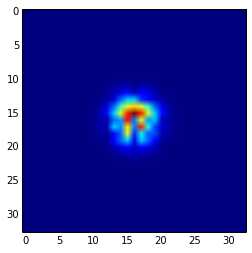

In [11]:
i = lx + 50
j = ly + 35
local_input = input[i-lw:i+lw+1, j-lw:j+lw+1]
toplot = local_input*0
sumg = 0

for k in range(pan):
    gaussianc = np.exp(-.5/sigma*np.linalg.norm([k-lw,0])**2)
    sumg += gaussianc
    toplot[k,lw] = local_input[k,lw] * gaussianc
    for l in range(1, lw+1, 8):
        toplot[k,lw+l:lw+l+8] = [local_input[k,lw+_]*np.exp(-.5/sigma*np.linalg.norm([k-lw,_])**2) for _ in range(l,l+8)]
        gaussianl = [np.exp(-.5/sigma*np.linalg.norm([k-lw,_])**2) for _ in range(l,l+8)]
        sumg += np.sum(gaussianl)
    for l in range(0, lw, 8):
        toplot[k,l:l+8] = [local_input[k,_]*np.exp(-.5/sigma*np.linalg.norm([k-lw,_-lw])**2) for _ in range(l,l+8)]
        gaussianr = [np.exp(-.5/sigma*np.linalg.norm([k-lw,_-lw])**2) for _ in range(l,l+8)]
        sumg += np.sum(gaussianr)

toplot /= sumg
plt.imshow(toplot);

Keep:

truncate = 4.

sigma = 4.

For now. This way I don't need to care about boundary pb.

---

# Cython code

## Cython implementation of Gaussian filter 

---

---

## Cython Bilateral filter

From [Wikipedia](https://en.wikipedia.org/wiki/Bilateral_filter)

The Bilateral filter has this formula:

$$I^\text{filtered}(x) = \frac{1}{W_p} \sum_{x_i \in \Omega} I(x_i)f_r(\|I(x_i)-I(x)\|)g_s(\|x_i-x\|)$$

Here we take $f_r$ and $g_s$ to be the same Gaussian distribution

We need to compute the normalization within the loops

[paper to read for bilateral](https://people.csail.mit.edu/fredo/PUBLI/Siggraph2002/)


---

## Performance of serial cython code

In [12]:
import sys
import os.path
sys.path.append(os.path.join('.', 'util'))

import set_compiler
set_compiler.install()

import pyximport
pyximport.install()

from timer import Timer

from gaussian_filter import cython_gaussian, cython_bilateral
from gaussian_filter import cython_gaussian_pr
from gaussian_filter import cython_gaussian_pr2
from gaussian_filter import cython_gaussian_pr3

General framework to benchmark cython functions

In [13]:
truncate = 4.
sigma = 4.
imagename = 'small.png'

# get ideal side sizes from arguments
lw = int(truncate*sigma+0.5)
pan = 2*lw+1

# for now we take values on the right until it fills a multiple of 8
# AVX is in x direction (in the matrix)
span = (pan // 8 + 1) * 8

# load image (only one color now)
f = misc.imread(imagename)
f = f[:,:,0]
output = f*0.

# add span-1 the -1 is because there is always at least one from the original image
lx, ly = f.shape
spx, spy = np.array([lx + span-1, ly + pan-1])

# add halo
input = np.zeros((3*lx,3*ly))
for i in range(3):
    for j in range(3):
            input[i*lx:(i+1)*lx, j*ly:(j+1)*ly] = f

cython gaussian 1.20690488815


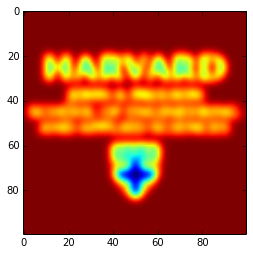

In [14]:
#initialize output and input for Gaussian blur
output =  np.array(output, np.float32)
input = np.array(input, np.float32)

start = time.time()
cython_gaussian(input, output, lw, pan, lx, ly, sigma)
print "cython gaussian", time.time() - start
plt.imshow(output);

cython bilateral 1.5977370739


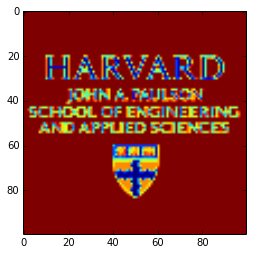

In [15]:
#initialize output and input for bilateral filter
output = f*0.
output2 =  np.array(output, np.float32)

start = time.time()
cython_bilateral(input, output2, lw, pan, lx, ly, sigma)
print "cython bilateral", time.time() - start
plt.imshow(output2);

The cython serial function designed for AVX is about twice slower than the python vectorized implementation and about 6 times slower than the scipy orpitmized function

---

## prange issue and solution

When going to the most inner loop the image gets less wrong. We debug using the Gaussian blur function.

I solved the problem, but I don't really understand why. I was writing in the output array for every pixel in the window. The solution is to use another variable that is updated for each pixel of the window and that writes into the output once the computation is done.

It would be intersting to see the results with 4 threads. Maybe it is already faster than the vectorized python algorithm.

##### When the prange is done on the k loop. The results are very wrong.
This is the best version without AVX

cython gaussian 0.829459905624


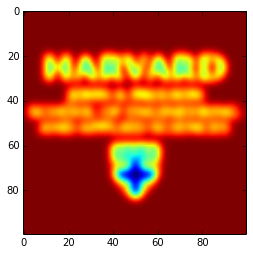

In [16]:
#initialize output and input for Gaussian blur
output =  np.array(output, np.float32)
input = np.array(input, np.float32)

start = time.time()
# The last input is the nb of threads
cython_gaussian_pr3(input, output, lw, pan, lx, ly, sigma, 2)
print "cython gaussian", time.time() - start
plt.imshow(output);

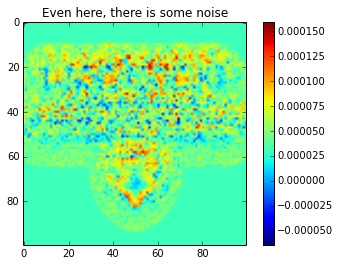

In [17]:
plt.imshow(output - output_ini);
plt.colorbar()
plt.title("Even here, there is some noise")

cython gaussian 1.59888005257


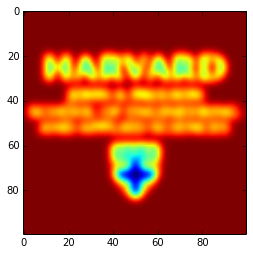

In [18]:
#initialize output and input for Gaussian blur
output =  np.array(output, np.float32)
input = np.array(input, np.float32)

start = time.time()
# The last input is the nb of threads
cython_gaussian_pr3(input, output, lw, pan, lx, ly, sigma, 1)
print "cython gaussian", time.time() - start
plt.imshow(output);

##### When the prange is done at the AVX level the result looks a little better.

cython gaussian 13.6375319958


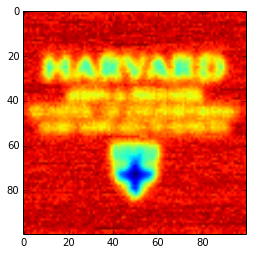

In [19]:
#initialize output and input for Gaussian blur
output =  np.array(output, np.float32)
input = np.array(input, np.float32)

start = time.time()
# The last input is the nb of threads
cython_gaussian_pr(input, output, lw, pan, lx, ly, sigma,2)
print "cython gaussian", time.time() - start
plt.imshow(output);

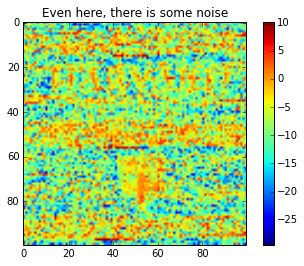

In [20]:
plt.imshow(output - output_ini);
plt.colorbar()
plt.title("Even here, there is some noise")

It runs faster and better when we have only one thread!

cython gaussian 4.66607689857


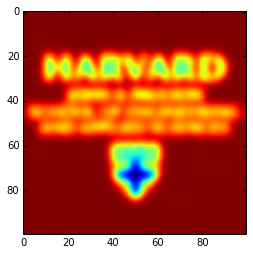

In [21]:
#initialize output and input for Gaussian blur
output =  np.array(output, np.float32)
input = np.array(input, np.float32)

start = time.time()
# The last input is the nb of threads
cython_gaussian_pr(input, output, lw, pan, lx, ly, sigma,1)
print "cython gaussian", time.time() - start
plt.imshow(output);

##### When we don't use the coef and local_value as variable the result is even better though not perfect.
It indicates us that the variables might get overwritten accros different thread.

cython gaussian 13.3594930172


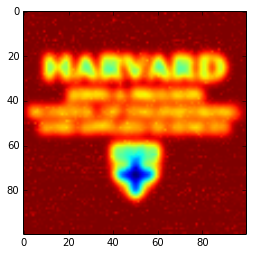

In [22]:
#initialize output and input for Gaussian blur
output =  np.array(output, np.float32)
input = np.array(input, np.float32)

start = time.time()
# The last input is the nb of threads
cython_gaussian_pr2(input, output, lw, pan, lx, ly, sigma,2)
print "cython gaussian", time.time() - start
plt.imshow(output);

#### Difference with what it should be:

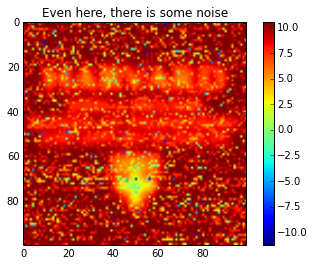

In [23]:
plt.imshow(output - output_ini);
plt.colorbar()
plt.title("Even here, there is some noise")

In this case the only variable that is changed is output[i-lx,j-ly]
One solution might be locking output[i-lx,j-ly] which would serialize and which is not wanted.

The function is also 5 times slower when using prange with 2 threads.

### Debugged prange for bilateral

cython gaussian 2.22629404068


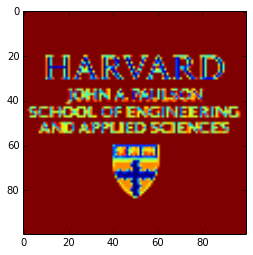

In [24]:
from gaussian_filter import cython_bilateral_pr

#initialize output and input for Gaussian blur
output =  np.array(output, np.float32)
input = np.array(input, np.float32)

start = time.time()
# The last input is the nb of threads
cython_bilateral_pr(input, output, lw, pan, lx, ly, sigma,2)
print "cython gaussian", time.time() - start
plt.imshow(output);

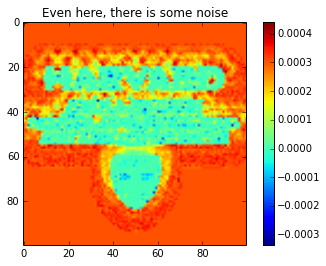

In [25]:
plt.imshow(output - output2);
plt.colorbar()
plt.title("Even here, there is some noise")

The difference is very small!

---

# AVX

We need the exp function in AVX which is not implemented yet.

For this we used the function from this [website](http://software-lisc.fbk.eu/avx_mathfun/avx_mathfun.h)

Need for a machine that supports AVX natively

# ! do without exp for now !

Because of difficulties with my emulator of AVX, I can't have an exp function in AVX.
I develop the code skipping the exp

#### Result to compare against

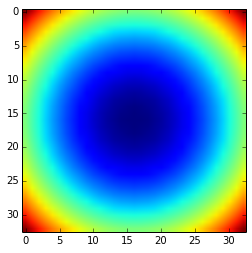

In [26]:
gaussianfilter = np.zeros((pan,pan))
for i in range(0,lw+1):
    for j in range(0,lw+1):
        gaussianfilter[i+lw,j+lw] = np.linalg.norm([i,j])
        gaussianfilter[-i+lw,-j+lw] = np.linalg.norm([i,j])
        gaussianfilter[-i+lw,j+lw] = np.linalg.norm([i,j])
        gaussianfilter[i+lw,-j+lw] = np.linalg.norm([i,j])
        
gaussianfilter = np.array(gaussianfilter)
gaussianfilter **= 2
gaussianfilter *= -.5/sigma
# gaussianfilter = np.exp(gaussianfilter)
gaussianfilter /= np.sum(gaussianfilter)
plt.imshow(gaussianfilter)

python 0.569580078125


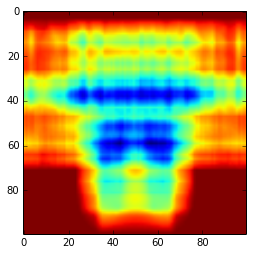

In [27]:
output_AVX = output * 0
start = time.time()
for i in range(lx,2*lx):
    for j in range(ly,2*ly):
        local_input = input[i-lw:i+lw+1, j-lw:j+lw+1]
        output_AVX[i-lx,j-ly]= np.sum(local_input*gaussianfilter)
plt.imshow(output_AVX);
print "python", time.time() - start

#### Same output with AVX

We see that the AVX + prange function gives the same output

In [28]:
from AVX_filtercode import cython_gaussian_AVX, cython_gaussian_AVX_pr, cython_bilateral_AVX_pr

AVX gaussian 1.18495893478


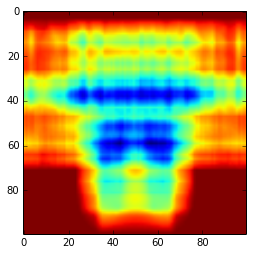

In [29]:
#initialize output and input for Gaussian blur
output =  np.array(output, np.float32)
input = np.array(input, np.float32)

start = time.time()
# The last input is the nb of threads
cython_gaussian_AVX(input, output, lw, pan, lx, ly, sigma,2)
print "AVX gaussian", time.time() - start
plt.imshow(output);

/usr/lib/pymodules/python2.7/matplotlib/colorbar.py:829: RuntimeWarning: invalid value encountered in divide
  z = np.take(y, i0) + (xn - np.take(b, i0)) * dy / db
/usr/lib/pymodules/python2.7/matplotlib/colorbar.py:581: RuntimeWarning: invalid value encountered in greater
  inrange = (ticks > -0.001) & (ticks < 1.001)
/usr/lib/pymodules/python2.7/matplotlib/colorbar.py:581: RuntimeWarning: invalid value encountered in less
  inrange = (ticks > -0.001) & (ticks < 1.001)


<matplotlib.colorbar.Colorbar instance at 0x7fa49c03e320>

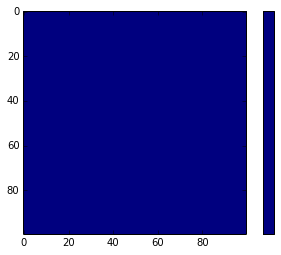

In [30]:
plt.imshow(output-output_AVX);
plt.colorbar()

The problem with prange seems to show up again (even though the difference is not very big)

AVX prange gaussian 1.14419603348


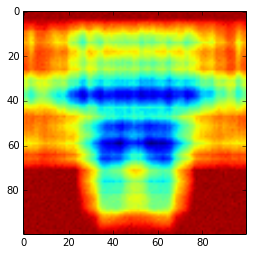

In [31]:
#initialize output and input for Gaussian blur
output =  np.array(output, np.float32)
input = np.array(input, np.float32)

start = time.time()
# The last input is the nb of threads
cython_gaussian_AVX_pr(input, output, lw, pan, lx, ly, sigma,2)
print "AVX prange gaussian", time.time() - start
plt.imshow(output);

<matplotlib.colorbar.Colorbar instance at 0x7fa496efd0e0>

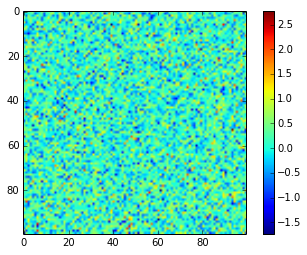

In [32]:
plt.imshow(output-output_AVX)
plt.colorbar()

### AVX bilateral filter

AVX prange gaussian 0.960686922073


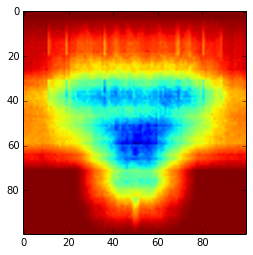

In [33]:
#initialize output and input for Gaussian blur
output =  np.array(output, np.float32)
input = np.array(input, np.float32)

start = time.time()
# The last input is the nb of threads
cython_bilateral_AVX_pr(input, output, lw, pan, lx, ly, sigma,2)
print "AVX prange gaussian", time.time() - start
plt.imshow(output);

---

# Benchmark

#### gaussian

In [35]:
timelist = []
X = 100
# run X time and average
for _ in range(X):
    output =  np.array(output, np.float32)
    input = np.array(input, np.float32)
    start = time.time()
    cython_gaussian_pr3(input, output, lw, pan, lx, ly, sigma,2)
    interval = time.time() - start
    timelist.append(interval)

timelist = np.array(timelist)
print "For gaussian filter prange the average time over ", X, "repetition is ", np.mean(timelist)

For gaussian filter prange the average time over  100 repetition is  1.3196916914


In [36]:
timelist = []
X = 100
# run X time and average
for _ in range(X):
    output =  np.array(output, np.float32)
    input = np.array(input, np.float32)
    start = time.time()
    cython_gaussian_AVX_pr(input, output, lw, pan, lx, ly, sigma,2)
    interval = time.time() - start
    timelist.append(interval)

timelist = np.array(timelist)
print "For AVX gaussian filter prange the average time over ", X, "repetition is ", np.mean(timelist)

For AVX gaussian filter prange the average time over  100 repetition is  1.31660323858


In [37]:
timelist = []
X = 100
# run X time and average
for _ in range(X):
    output =  np.array(output, np.float32)
    input = np.array(input, np.float32)
    start = time.time()
    gaussian_filter(f, 2)
    interval = time.time() - start
    timelist.append(interval)

timelist = np.array(timelist)
print "For scipy the average time over ", X, "repetition is ", np.mean(timelist)

For scipy the average time over  100 repetition is  0.00105718135834


In [38]:
timelist = []
X = 100
# run X time and average
for _ in range(X):
    output =  np.array(output, np.float32)
    input = np.array(input, np.float32)
    start = time.time()
    for i in range(lx,2*lx):
        for j in range(ly,2*ly):
            local_input = input[i-lw:i+lw+1, j-lw:j+lw+1]
            output[i-lx,j-ly]= np.sum(local_input*gaussianfilter)
    interval = time.time() - start
    timelist.append(interval)

timelist = np.array(timelist)
print "For vectorized python the average time over ", X, "repetition is ", np.mean(timelist)

For vectorized python the average time over  100 repetition is  0.539725141525


We are still slower than built in function and vectorized python. However, we should keep in mind that the algorithm also suits bilateral filtering which scipy and vectorized python cannot support.

#### bilateral

In [40]:
timelist = []
X = 100
# run X time and average
for _ in range(X):
    output =  np.array(output, np.float32)
    input = np.array(input, np.float32)
    start = time.time()
    cython_bilateral_pr(input, output, lw, pan, lx, ly, sigma,2)
    interval = time.time() - start
    timelist.append(interval)

timelist = np.array(timelist)
print "For bilateral filter prange the average time over ", X, "repetition is ", np.mean(timelist)

For bilateral filter prange the average time over  100 repetition is  2.41152614117


In [41]:
timelist = []
X = 100
# run X time and average
for _ in range(X):
    output =  np.array(output, np.float32)
    input = np.array(input, np.float32)
    start = time.time()
    cython_bilateral_AVX_pr(input, output, lw, pan, lx, ly, sigma,2)
    interval = time.time() - start
    timelist.append(interval)

timelist = np.array(timelist)
print "For AVX bilateral filter prange the average time over ", X, "repetition is ", np.mean(timelist)

For AVX bilateral filter prange the average time over  100 repetition is  1.28838824987


AVX twice as fast as prange.

---

Odyssey

[Intro to Odyssey](https://github.com/fasrc/cs205_Intro_to_Odyssey)

---

Further performance

[perf](https://perf.wiki.kernel.org/index.php/Main_Page)